# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
from im_tutorials.data.cordis import cordis_table

# Import Data

In [2]:
# merge organisations, project_organisations, projects
cordis_orgs_df = cordis_table('organisations')
cordis_project_orgs_df = cordis_table('project_organisations')
cordis_projects_df = cordis_table('projects')
cordis_full_df = cordis_project_orgs_df.merge(
    cordis_projects_df, left_on='project_rcn', right_on='rcn', how='left'
)
cordis_full_df = cordis_full_df.merge(
    cordis_orgs_df, left_on='organization_id', right_on='id', how='left'
)
cordis_full_df = cordis_full_df [(cordis_full_df['activity_type'] == 'Private for-profit entities (excluding Higher or Secondary Education Establishments)')
  & (cordis_full_df['framework'] == 'H2020')]

cordis_full_df.head()
cordis_full_df.columns

Index(['project_rcn', 'organization_id', 'activity_type', 'address',
       'contribution', 'type', 'website_x', 'rcn', 'acronym', 'end_date_code',
       'ec_contribution', 'framework', 'funding_scheme', 'funded_under',
       'objective', 'project_description', 'start_date_code', 'status',
       'title', 'total_cost', 'website_y', 'id', 'name', 'country_code',
       'country_name'],
      dtype='object')

In [3]:
cordis_full_df.head()

,project_rcn,organization_id,activity_type,address,contribution,type,website_x,rcn,acronym,end_date_code,...,project_description,start_date_code,status,title,total_cost,website_y,id,name,country_code,country_name
135899,193157,999905974,Private for-profit entities (excluding Higher ...,"{'city': 'LONDON', 'street': 'GIBBS BUILDING, ...",230000,coordinator,www.wellcome.ac.uk,193157,ERC-EuropePMC-1-2014,2016-03-31,...,,2014-01-01,None,Support towards the Europe PMC initiative-Cont...,230000,http://europepmc.org,999905974,THE WELLCOME TRUST LIMITED,GB,United Kingdom
135943,193160,999574428,Private for-profit entities (excluding Higher ...,"{'city': 'CAMBRIDGE', 'street': 'KINGS PARADE ...",20000,participant,,193160,MACC-III,2015-08-31,...,,2014-08-01,CLOSED,Monitoring Atmospheric Composition and Climate...,5000000,http://atmosphere.copernicus.eu,999574428,CAMBRIDGE ENVIRONMENTAL RESEARCH CONSULTANTS LTD,GB,United Kingdom
135953,193160,999940118,Private for-profit entities (excluding Higher ...,"{'city': 'TOULOUSE', 'street': 'Avenue Gaspard...",35000,participant,www.cerfacs.fr,193160,MACC-III,2015-08-31,...,,2014-08-01,CLOSED,Monitoring Atmospheric Composition and Climate...,5000000,http://atmosphere.copernicus.eu,999940118,CENTRE EUROPEEN DE RECHERCHE ET DE FORMATION A...,FR,France
135972,193161,984286452,Private for-profit entities (excluding Higher ...,"{'city': 'HAMBURG', 'street': 'CHRYSANDERSTRAS...",31608,participant,www.brockmann-consult.de,193161,MyOcean FO,2015-05-31,...,,2014-10-01,None,Pre-Operational Marine Service Continuity in T...,6000000,http://www.myocean.eu,984286452,BROCKMANN CONSULT GMBH,DE,Germany
135977,193161,998142126,Private for-profit entities (excluding Higher ...,"{'city': 'RAMONVILLE ST AGNE', 'street': '11 R...",551450,participant,www.cls.fr,193161,MyOcean FO,2015-05-31,...,,2014-10-01,None,Pre-Operational Marine Service Continuity in T...,6000000,http://www.myocean.eu,998142126,COLLECTE LOCALISATION SATELLITES,FR,France


# Add labels and features

In [4]:
# Add num_success, group_multiple_success
cordis_full_df_sorted = cordis_full_df.sort_values(by=['organization_id', 'start_date_code'])
cordis_full_df_sorted = cordis_full_df_sorted.reset_index(drop=True)
cordis_full_df_sorted['num_success'] = cordis_full_df_sorted.groupby(['organization_id']).cumcount()
cordis_full_df_sorted['multiple_success'] = cordis_full_df_sorted.groupby(['organization_id'])['num_success'].transform('max')
cordis_full_df_sorted['group_multiple_success'] = (cordis_full_df_sorted['multiple_success'] > 0) * 1
cordis_full_df_sorted.columns

Index(['project_rcn', 'organization_id', 'activity_type', 'address',
       'contribution', 'type', 'website_x', 'rcn', 'acronym', 'end_date_code',
       'ec_contribution', 'framework', 'funding_scheme', 'funded_under',
       'objective', 'project_description', 'start_date_code', 'status',
       'title', 'total_cost', 'website_y', 'id', 'name', 'country_code',
       'country_name', 'num_success', 'multiple_success',
       'group_multiple_success'],
      dtype='object')

In [5]:
cordis_full_df_sorted['group_multiple_success'].value_counts()

1    23018
0    14120
Name: group_multiple_success, dtype: int64

In [6]:
# Add funded_under_title
def fundedUnder2Title(x):
    return x[0]['title']

cordis_full_df_sorted['funded_under_title'] = cordis_full_df_sorted['funded_under'].apply(fundedUnder2Title)

In [7]:
# Add funding_scheme_mean_ec_contribution
cordis_full_df_sorted['funding_scheme_mean_ec_contribution'] = cordis_full_df_sorted.groupby(['funding_scheme'])['ec_contribution'].transform(np.mean)

# Add funding_scheme_total_ec_contribution
cordis_full_df_sorted['funding_scheme_total_ec_contribution'] = cordis_full_df_sorted.groupby(['funding_scheme'])['ec_contribution'].transform(np.sum)

# Add importance
cordis_full_df_sorted['importance'] = cordis_full_df_sorted['contribution'] / cordis_full_df_sorted['ec_contribution']

# Add num_of_partners
cordis_full_df_sorted['num_of_partners'] = cordis_full_df_sorted.groupby(['project_rcn'])['organization_id'].transform('count')

# Add funding_country_mean_ec_contribution
cordis_full_df_sorted['country_mean_ec_contribution'] = cordis_full_df_sorted.groupby(['country_code'])['ec_contribution'].transform(np.mean)

# Add funding_country_total_ec_contribution
cordis_full_df_sorted['country_total_ec_contribution'] = cordis_full_df_sorted.groupby(['country_code'])['ec_contribution'].transform(np.sum)

# Add funded_under_mean_ec_contribution
cordis_full_df_sorted['funded_under_mean_ec_contribution'] = cordis_full_df_sorted.groupby(['funded_under_title'])['ec_contribution'].transform(np.mean)

# Add funded_under_total_ec_contribution
cordis_full_df_sorted['funded_under_total_ec_contribution'] = cordis_full_df_sorted.groupby(['funded_under_title'])['ec_contribution'].transform(np.sum)

# Add partner_max_multiple_success
cordis_full_df_sorted['max_success_partner'] = cordis_full_df_sorted.groupby(['project_rcn'])['multiple_success'].transform('max')

# Add "CLOSED","ONGOING","SIGNED","TERMINATED"
cordis_full_df_sorted = pd.concat([cordis_full_df_sorted, pd.get_dummies(cordis_full_df_sorted['status'])], axis=1)

# Add participant, coordinator, partner
cordis_full_df_sorted = pd.concat([cordis_full_df_sorted, pd.get_dummies(cordis_full_df_sorted['type'])], axis=1)

In [8]:
cordis_full_df_sorted.columns

Index(['project_rcn', 'organization_id', 'activity_type', 'address',
       'contribution', 'type', 'website_x', 'rcn', 'acronym', 'end_date_code',
       'ec_contribution', 'framework', 'funding_scheme', 'funded_under',
       'objective', 'project_description', 'start_date_code', 'status',
       'title', 'total_cost', 'website_y', 'id', 'name', 'country_code',
       'country_name', 'num_success', 'multiple_success',
       'group_multiple_success', 'funded_under_title',
       'funding_scheme_mean_ec_contribution',
       'funding_scheme_total_ec_contribution', 'importance', 'num_of_partners',
       'country_mean_ec_contribution', 'country_total_ec_contribution',
       'funded_under_mean_ec_contribution',
       'funded_under_total_ec_contribution', 'max_success_partner', 'CLOSED',
       'ONGOING', 'SIGNED', 'TERMINATED', 'coordinator', 'participant',
       'partner'],
      dtype='object')

# NLP and clustering

In [9]:
from im_tutorials.features.text_preprocessing import clean_and_tokenize
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, Isomap
from bokeh.palettes import Category20_16
from bokeh.models import ColumnDataSource, Circle, Line
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Circle, Line
from bokeh.models import PrintfTickFormatter, HoverTool
from bokeh.palettes import Category10
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
import re
# ' '.join(clean_and_tokenize('hi there i am george and i like docs'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dlshcbmui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/dlshcbmui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
cordis_full_df_sorted['tokenize_title'] = cordis_full_df_sorted['title'].apply(clean_and_tokenize)
cordis_full_df_sorted['tokenize_title'] = cordis_full_df_sorted['tokenize_title'].apply(' '.join)
cordis_full_df_sorted['tokenize_title'].head()

0    international inter_sectoral inter_disciplinar...
1                             political concepts world
2    international doctoral training mathematical s...
3    european training network sustainable multi_fu...
4    sustainable organic coatings corrosion protection
Name: tokenize_title, dtype: object

In [11]:
cordis_full_df_sorted['tokenize_objective'] = cordis_full_df_sorted['objective'].str.replace("<br/>", "").apply(clean_and_tokenize)
cordis_full_df_sorted['tokenize_objective'] = cordis_full_df_sorted['tokenize_objective'].apply(' '.join)
cordis_full_df_sorted['tokenize_objective'].head()

0    raised willpower provence alpes cote azur key ...
1    politico phd programme build success interdisc...
2    cofund mathinparis programme create build upon...
3    sustainable multi_functional automated resilie...
4    background need requirement improve sustainabi...
Name: tokenize_objective, dtype: object

In [12]:
cordis_full_df_sorted['tokenize_text'] = cordis_full_df_sorted['tokenize_title'] + cordis_full_df_sorted['tokenize_objective']
cordis_full_df_sorted['tokenize_text'].head()

0    international inter_sectoral inter_disciplinar...
1    political concepts worldpolitico phd programme...
2    international doctoral training mathematical s...
3    european training network sustainable multi_fu...
4    sustainable organic coatings corrosion protect...
Name: tokenize_text, dtype: object

In [13]:
# Ways to improve: use also the description, and more (publication)
# Ways to improve: filter out the bad data, e.g., shorter than 3 words
cordis_full_df_sorted['tokenize_text'].values[:10]

array(['international inter_sectoral inter_disciplinary doctoral training programme aix_marseille universityraised willpower provence alpes cote azur key regional actors research innovation offer promising early stage researchers international inter_sectoral inter_disciplinary innovative doctoral training programme excellence ensured research ecosystem aix_marseille university also open transparent merit_based impartial equitable selection process set assess perfect match proposed doctoral projects esrs ensure best career perspectives esr graduation set original training programme offering training scheme combining options international inter_sectoral interdisciplinary dimensions including comprehensive package transferable skills training along specific mentoring scheme involving academic supervisor non_academic international tutor scientific training supervisory committee apart recruitment esrs expected enhance skills amu esrs including transferrable ones upgrade amu doctorate curric

In [14]:
token_counts = Counter(chain(*[x.split(' ') for x in cordis_full_df_sorted['tokenize_text']]))
token_counts.most_common(40)

[('project', 45366),
 ('new', 35806),
 ('energy', 31465),
 ('data', 28771),
 ('european', 28560),
 ('research', 26345),
 ('technology', 24368),
 ('market', 23929),
 ('system', 23595),
 ('development', 22730),
 ('systems', 22471),
 ('technologies', 20726),
 ('based', 19214),
 ('innovative', 19137),
 ('industry', 18068),
 ('solutions', 17960),
 ('high', 17713),
 ('develop', 17305),
 ('use', 17256),
 ('management', 16903),
 ('innovation', 16410),
 ('europe', 16269),
 ('production', 16203),
 ('process', 16097),
 ('design', 15728),
 ('industrial', 15624),
 ('services', 15468),
 ('business', 14586),
 ('network', 14430),
 ('support', 14242),
 ('platform', 14187),
 ('also', 14090),
 ('tools', 13903),
 ('provide', 13785),
 ('different', 13012),
 ('partners', 12525),
 ('integrated', 12463),
 ('applications', 12325),
 ('approach', 12303),
 ('well', 12175)]

In [15]:
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.5, stop_words='english')
tfidf_vecs = tfidf_vectorizer.fit_transform(cordis_full_df_sorted['tokenize_text'])

In [16]:
tfidf_vecs.shape

(37138, 21038)

In [17]:
# n_component should be somewhere in the middle
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
svd_vecs = svd.fit_transform(tfidf_vecs)
svd_vecs.shape

(37138, 50)

In [18]:
clf = KMeans(n_clusters=20, random_state=0)
clf.fit(svd_vecs)
species = clf.predict(svd_vecs)
species.shape

(37138,)

In [19]:
cordis_full_df_sorted['text_species'] = species

In [20]:
cordis_full_df_sorted['text_species'].value_counts()

13    9201
5     5881
1     3138
15    3080
4     2727
0     2241
8     2082
2     1985
12    1470
9     1260
14     992
16     726
6      620
17     559
3      337
18     332
7      238
10     125
19      77
11      67
Name: text_species, dtype: int64

In [21]:
index = np.random.randint(low = 0, high = species.shape[0] - 1, size = 2000)
svd_vecs[index].shape

(2000, 50)

In [22]:
tsne = TSNE(n_components=2)
tsne_vecs = tsne.fit_transform(svd_vecs[index])
tsne_vecs.shape

(2000, 2)

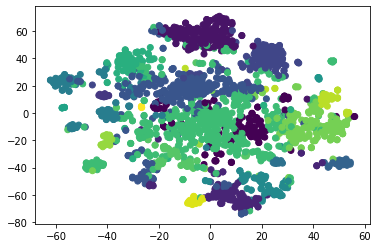

In [23]:
plt.scatter(tsne_vecs[:, 0], tsne_vecs[:, 1], c=cordis_full_df_sorted['text_species'][index])

In [24]:
# WIP: interactive plot
'''
colors = [Category20_16[g] for g in cordis_full_df_sorted['text_species'][index]]
cds = ColumnDataSource(data={
    'tsne_0': tsne_vecs[:, 0],
    'tsne_1': tsne_vecs[:, 1],
    'color': colors,
    'goal': cordis_full_df_sorted['text_species'][index],
    'title': cordis_full_df_sorted['title'][index],
    'id': index
})
'''

"\ncolors = [Category20_16[g] for g in cordis_full_df_sorted['text_species'][index]]\ncds = ColumnDataSource(data={\n    'tsne_0': tsne_vecs[:, 0],\n    'tsne_1': tsne_vecs[:, 1],\n    'color': colors,\n    'goal': cordis_full_df_sorted['text_species'][index],\n    'title': cordis_full_df_sorted['title'][index],\n    'id': index\n})\n"

In [25]:
token_counts = Counter(chain(*[x.split(' ') for x in cordis_full_df_sorted[cordis_full_df_sorted['text_species'] == 7]['tokenize_text']]))
token_counts.most_common(40)

[('hydrogen', 1675),
 ('project', 581),
 ('fuel', 578),
 ('vehicles', 499),
 ('cell', 421),
 ('refuelling', 418),
 ('new', 382),
 ('europe', 380),
 ('bus', 371),
 ('mobility', 331),
 ('buses', 327),
 ('energy', 309),
 ('stations', 279),
 ('scale', 238),
 ('sector', 233),
 ('system', 229),
 ('technology', 225),
 ('deployment', 202),
 ('european', 202),
 ('demonstrate', 197),
 ('test', 188),
 ('transport', 181),
 ('station', 180),
 ('hrs', 175),
 ('cost', 172),
 ('fcevs', 168),
 ('range', 165),
 ('large', 160),
 ('applications', 159),
 ('provide', 159),
 ('across', 157),
 ('public', 154),
 ('solutions', 152),
 ('high', 147),
 ('fleets', 143),
 ('required', 139),
 ('vehicle', 138),
 ('development', 137),
 ('storage', 137),
 ('trucks', 133)]

In [26]:
token_counts = Counter(chain(*[x.split(' ') for x in cordis_full_df_sorted[cordis_full_df_sorted['text_species'] == 0]['tokenize_text']]))
token_counts.most_common(40)

[('manufacturing', 7075),
 ('production', 3856),
 ('project', 3619),
 ('process', 3060),
 ('technology', 2739),
 ('new', 2505),
 ('european', 2231),
 ('pilot', 2194),
 ('industry', 2191),
 ('industrial', 2099),
 ('smart', 2075),
 ('line', 2021),
 ('processes', 1878),
 ('technologies', 1869),
 ('development', 1814),
 ('high', 1697),
 ('design', 1578),
 ('systems', 1476),
 ('advanced', 1468),
 ('data', 1437),
 ('based', 1417),
 ('materials', 1413),
 ('integrated', 1356),
 ('chain', 1320),
 ('europe', 1319),
 ('system', 1308),
 ('control', 1298),
 ('products', 1274),
 ('components', 1254),
 ('solutions', 1253),
 ('cost', 1242),
 ('platform', 1205),
 ('market', 1148),
 ('power', 1133),
 ('innovative', 1117),
 ('value', 1113),
 ('digital', 1090),
 ('integration', 1088),
 ('equipment', 1071),
 ('applications', 1036)]

In [27]:
token_counts = Counter(chain(*[x.split(' ') for x in cordis_full_df_sorted[cordis_full_df_sorted['text_species'] == 16]['tokenize_text']]))
token_counts.most_common(40)

[('atm', 1582),
 ('airport', 1162),
 ('european', 1108),
 ('operations', 1096),
 ('air', 1059),
 ('management', 967),
 ('sesar', 907),
 ('traffic', 897),
 ('project', 797),
 ('airspace', 788),
 ('aircraft', 733),
 ('performance', 721),
 ('network', 708),
 ('airports', 665),
 ('service', 628),
 ('system', 610),
 ('new', 582),
 ('ground', 577),
 ('systems', 573),
 ('information', 543),
 ('solutions', 533),
 ('operational', 506),
 ('safety', 495),
 ('navigation', 484),
 ('support', 459),
 ('solution', 456),
 ('trajectory', 451),
 ('level', 451),
 ('flight', 436),
 ('provide', 418),
 ('use', 405),
 ('impact', 403),
 ('integration', 402),
 ('stakeholders', 398),
 ('future', 379),
 ('improve', 375),
 ('capacity', 369),
 ('europe', 357),
 ('data', 349),
 ('key', 349)]

In [28]:
cordis_full_df_sorted = pd.concat([cordis_full_df_sorted, pd.get_dummies(cordis_full_df_sorted['text_species'], prefix="text")], axis=1)

In [29]:
cordis_full_df_sorted.columns

Index(['project_rcn', 'organization_id', 'activity_type', 'address',
       'contribution', 'type', 'website_x', 'rcn', 'acronym', 'end_date_code',
       'ec_contribution', 'framework', 'funding_scheme', 'funded_under',
       'objective', 'project_description', 'start_date_code', 'status',
       'title', 'total_cost', 'website_y', 'id', 'name', 'country_code',
       'country_name', 'num_success', 'multiple_success',
       'group_multiple_success', 'funded_under_title',
       'funding_scheme_mean_ec_contribution',
       'funding_scheme_total_ec_contribution', 'importance', 'num_of_partners',
       'country_mean_ec_contribution', 'country_total_ec_contribution',
       'funded_under_mean_ec_contribution',
       'funded_under_total_ec_contribution', 'max_success_partner', 'CLOSED',
       'ONGOING', 'SIGNED', 'TERMINATED', 'coordinator', 'participant',
       'partner', 'tokenize_title', 'tokenize_objective', 'tokenize_text',
       'text_species', 'text_0', 'text_1', 'text_2', '

# Prepare data set

In [30]:
input_var_cont = ['contribution',
                  'ec_contribution',
                  'total_cost',
                  'funding_scheme_mean_ec_contribution',
                  'funding_scheme_total_ec_contribution',
                  'importance',
                  'num_of_partners',
                  'country_mean_ec_contribution',
                  'country_total_ec_contribution',
                  'funded_under_mean_ec_contribution',
                  'funded_under_total_ec_contribution',
                  'max_success_partner'
                 ]

input_var_species = ["text_" + str(i) for i in range(20)]

input_var_disc = ["CLOSED",
                 "ONGOING",
                 "SIGNED",
                 "TERMINATED",
                 "participant",
                 "coordinator",
                 "partner"
                 ]

output_var = ['group_multiple_success']

all_var = input_var_cont + input_var_species + input_var_disc + output_var

In [31]:
cordis_full_df_filtered_num_success = cordis_full_df_sorted[cordis_full_df_sorted['num_success'] == 0]
cordis_full_df_group_multiple_success = cordis_full_df_filtered_num_success[all_var]

In [32]:
normalized_df_group_multiple_success = (cordis_full_df_group_multiple_success - cordis_full_df_group_multiple_success.min())/(cordis_full_df_group_multiple_success.max() - cordis_full_df_group_multiple_success.min())
normalized_df_group_multiple_success.head()

,contribution,ec_contribution,total_cost,funding_scheme_mean_ec_contribution,funding_scheme_total_ec_contribution,importance,num_of_partners,country_mean_ec_contribution,country_total_ec_contribution,funded_under_mean_ec_contribution,...,text_18,text_19,CLOSED,ONGOING,SIGNED,TERMINATED,participant,coordinator,partner,group_multiple_success
0,0.0,0.012223,0.018269,0.023642,0.003816,0.0,0.057143,0.597517,0.859562,0.023269,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.004872,0.007308,0.023642,0.003816,0.0,0.014286,0.454185,0.199870,0.023269,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.016307,0.024359,0.023642,0.003816,0.0,0.100000,0.597517,0.859562,0.023269,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.020740,0.015484,0.045120,0.146396,0.0,0.242857,0.597517,0.859562,0.038379,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.006616,0.004954,0.022622,0.009816,0.0,0.042857,0.417917,0.686275,0.038379,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
normalized_df_group_multiple_success[10000:10020]

,contribution,ec_contribution,total_cost,funding_scheme_mean_ec_contribution,funding_scheme_total_ec_contribution,importance,num_of_partners,country_mean_ec_contribution,country_total_ec_contribution,funded_under_mean_ec_contribution,...,text_18,text_19,CLOSED,ONGOING,SIGNED,TERMINATED,participant,coordinator,partner,group_multiple_success
12630,0.001118,0.000231,0.000277,0.000000,0.002984,1.000000,0.000000,0.220746,0.012581,0.003012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12631,0.007741,0.165543,0.689562,0.235155,0.215497,0.010877,0.485714,0.525243,1.000000,0.163377,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12632,0.005349,0.081946,0.083610,0.101740,1.000000,0.015181,0.571429,0.412837,0.044031,0.073261,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12634,0.002815,0.014708,0.018175,0.072748,0.990749,0.044443,0.042857,0.412404,0.025827,0.052317,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12635,0.000671,0.093635,0.069831,0.072748,0.990749,0.001667,0.400000,0.446190,0.087249,0.073261,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12636,0.003917,0.093642,0.070250,0.072748,0.990749,0.009728,0.400000,0.466453,0.605130,0.073261,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12637,0.000337,0.000363,0.000292,0.004042,0.001588,0.200013,0.028571,0.525243,1.000000,0.002977,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12640,0.002767,0.013684,0.014617,0.041814,0.019723,0.046944,0.071429,0.381650,0.106505,0.067684,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12644,0.003680,0.018037,0.018893,0.101740,1.000000,0.047384,0.057143,0.597517,0.859562,0.019323,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12648,0.010407,0.027973,0.022599,0.072748,0.990749,0.086462,0.085714,0.597517,0.859562,0.081138,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [34]:
#sns.pairplot(normalized_df_group_multiple_success, hue='group_multiple_success', diag_kind='hist')

# Logistic regrssion + SVM

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as ss
from sklearn.metrics import classification_report

In [36]:
X, y = normalized_df_group_multiple_success[input_var_cont + input_var_species + input_var_disc], normalized_df_group_multiple_success['group_multiple_success']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,  # Iris is a pretty easy task so we make it a little harder
    shuffle=True,
    random_state=42,
)

In [37]:
lr_model = LogisticRegression(solver='lbfgs', penalty='none', max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
(pd.DataFrame(lr_model.coef_, columns=X.columns, index=['Results'])
 .assign(intercept=lr_model.intercept_)
 .assign(train_accuracy=lr_model.score(X_train, y_train)) # Train score
 .assign(test_accuracy=lr_model.score(X_test, y_test)) # Test score
 .T
)

,Results
contribution,13.853290
ec_contribution,0.818027
total_cost,0.891419
funding_scheme_mean_ec_contribution,-0.163051
funding_scheme_total_ec_contribution,0.015166
importance,-1.689467
num_of_partners,-1.153362
country_mean_ec_contribution,-0.007193
country_total_ec_contribution,0.069421
funded_under_mean_ec_contribution,1.235988


In [39]:
y_train.value_counts()

0.0    11307
1.0     4505
Name: group_multiple_success, dtype: int64

In [40]:
cv_kwargs = dict(scoring='f1', cv=5, n_jobs=-1, verbose=0)
scores = cross_val_score(lr_model, X_train, y_train, **cv_kwargs)
print(f"Average cross val score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Average cross val score: 0.303 (+/- 0.015)


In [41]:
param_grid_lr = [{'C': [0.1, 1, 10, 100],
               'penalty': ['l1', 'l2'],
               'solver': ['liblinear'],
               'max_iter': [1000],
              'intercept_scaling': [0.00010, 0.1, 0.5, 1, 5, 10]},
             {'solver': ['lbfgs'], 'penalty': ['none']}]

grid_lr = GridSearchCV(lr_model, param_grid_lr, **cv_kwargs)
grid_lr.fit(X_train, y_train)

print(f"Best parameters: {grid_lr.best_params_}, with score {grid_lr.best_score_:.3f}")

Best parameters: {'C': 100, 'intercept_scaling': 0.5, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}, with score 0.303


In [42]:
(pd.DataFrame(
    classification_report(y_test, grid_lr.predict(X_test), output_dict=True)
 ).T.round(3)
)

,precision,recall,f1-score,support
0.0,0.751,0.947,0.837,2813.000
1.0,0.631,0.225,0.331,1140.000
accuracy,0.738,0.738,0.738,0.738
macro avg,0.691,0.586,0.584,3953.000
weighted avg,0.716,0.738,0.691,3953.000


In [44]:
svm_model = SVC(C=1, kernel='rbf', gamma='auto')
param_grid_svm = {'C': [0.1],
              'gamma': [5],
              'kernel': ['poly'],
              'degree': [4]}
grid_svm = GridSearchCV(svm_model, param_grid_svm, **cv_kwargs)

grid_svm.fit(X_train, y_train)

print(f"Best parameters: {grid_svm.best_params_}, with score {grid_svm.best_score_:.3f}")

Best parameters: {'C': 0.1, 'degree': 4, 'gamma': 5, 'kernel': 'poly'}, with score 0.509


In [45]:
(pd.DataFrame(
    classification_report(y_test, grid_svm.predict(X_test), output_dict=True)
 ).T.round(3)
)

,precision,recall,f1-score,support
0.0,0.806,0.882,0.843,2813.000
1.0,0.622,0.477,0.540,1140.000
accuracy,0.765,0.765,0.765,0.765
macro avg,0.714,0.680,0.691,3953.000
weighted avg,0.753,0.765,0.755,3953.000


In [ ]:
# SVC
# Best parameters: {'C': 0.11666261799161694, 'degree': 4, 'gamma': 4.731854369498993, 'kernel': 'poly'}, with score 0.509
